This file uses the premade vector data frame that Rishabh created (for computational efficiency). Not generating vectors manually in this file. Vectors being used will be consistent.

Also, in this file everything is being run on all nodes/vectors (no subgraphs)

TRAINING

In [1]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm

import pandas as pd
import numpy

import math

import os
import random
# from gensim.models import Word2Vec
import networkx as nx
import seaborn as sns

# from skopt import BayesSearchCV
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, accuracy_score, roc_curve, auc, log_loss, RocCurveDisplay


In [2]:
node_df = pd.read_csv("../2024_05_05_meta_node_data.csv")
edge_df = pd.read_csv("../2024_04_24_meta_edge_sourcetarget_disease_pub_pli_reciprocal.csv")
vector_df = pd.read_csv("../df_node_embeddings_dim128_p0.5_q0.5_walk20_n_walks8_wlks_p_node100_cntxt10 (1).csv")
geneGraph = nx.DiGraph()
# %run vizfunctions.ipynb
node_df.set_index('id',inplace=True)
node_df.head()

/var/folders/96/9xbhwb7144d8448ncy51834c0000gn/T/ipykernel_52924/333237320.py:2: DtypeWarning: Columns (7,8) have mixed types. Specify dtype option on import or set low_memory=False.
  edge_df = pd.read_csv("../2024_04_24_meta_edge_sourcetarget_disease_pub_pli_reciprocal.csv")


,symbol,disease_assoc_cat,publication_count,ortholog_count,all_ortho_count
id,,,,,
7414,VCL,disease_assoc,279,5,"{'hsapien': {'entrezid': 7414, 'symbol': 'VCL'..."
4626,MYH8,disease_assoc,36,4,"{'hsapien': {'entrezid': 4626, 'symbol': 'MYH8..."
9722,NOS1AP,disease_assoc,141,5,"{'hsapien': {'entrezid': 9722, 'symbol': 'NOS1..."
9891,NUAK1,non_disease_assoc,70,5,"{'hsapien': {'entrezid': 9891, 'symbol': 'NUAK..."
81788,NUAK2,disease_assoc,46,2,"{'hsapien': {'entrezid': 81788, 'symbol': 'NUA..."


In [3]:
# Removing non_omim nodes
all_node_ids = []
for id in vector_df["id"]:
    all_node_ids.append(id)

int_node_ids = []
non_omim_ids = []
for id in all_node_ids:
    if node_df.loc[id]["disease_assoc_cat"] == "disease_assoc" or node_df.loc[id]["disease_assoc_cat"] == "non_disease_assoc":
        int_node_ids.append(id)
    elif node_df.loc[id]["disease_assoc_cat"] == "non_omim":
        non_omim_ids.append(id)

print(len(int_node_ids))
        

16220


In [4]:
# Removing non_omim nodes from df
non_omim_rows = vector_df[vector_df["id"].isin(non_omim_ids)]

training_vector_df = vector_df.drop(non_omim_rows.index)

training_vector_df.head()
print(len(training_vector_df))

16220


In [5]:
vector_df.head()

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,119,120,121,122,123,124,125,126,127,id
0,0,0.064558,-0.051640,-0.083797,0.062531,0.057180,0.014313,-0.052380,-0.103716,-0.015086,...,-0.007501,0.089192,-0.038257,-0.087094,0.034081,-0.069049,-0.071937,-0.055029,0.016416,7414
1,1,0.070410,-0.065505,-0.216953,-0.149399,-0.122614,-0.070443,0.028499,0.004111,-0.066796,...,0.084825,-0.092645,0.027228,0.032798,-0.143785,0.037345,-0.053298,0.003609,-0.092844,4626
2,2,0.070818,-0.080974,0.073398,-0.015023,-0.000077,-0.008002,-0.082583,-0.038015,0.044983,...,0.023089,-0.017646,0.096217,0.053226,0.070061,0.027838,-0.035029,0.055155,-0.056974,9722
3,3,0.107021,0.013994,0.036538,-0.063050,-0.086183,0.043723,0.145028,0.103949,0.036598,...,0.065681,0.009408,0.026440,-0.059795,0.049326,-0.024846,-0.041913,-0.001121,0.005391,9891
4,4,-0.392722,0.441372,0.236662,-0.245315,-0.104067,0.292547,-0.161585,-0.018632,0.061402,...,-0.021892,0.242594,-0.414570,0.134470,-0.121044,-0.388935,-0.150884,-0.295264,-0.248610,81788


In [8]:
# Data preprocessing

# Creating a dataset with just the genes, classification, and vectors
# vector_data = pd.DataFrame(vectors)
disease_assoc_cat = numpy.array([node_df.loc[node_id]['disease_assoc_cat'] for node_id in int_node_ids])
publication_count = numpy.array([node_df.loc[node_id]['publication_count'] for node_id in int_node_ids])
ortholog_count = numpy.array([node_df.loc[node_id]['ortholog_count'] for node_id in int_node_ids])
all_ortho_count = numpy.array([node_df.loc[node_id]['all_ortho_count'] for node_id in int_node_ids])


training_vector_df['gene'] = int_node_ids
# vector_data['publication count'] = publication_count
# vector_data['ortholog_count'] = ortholog_count
# vector_data['all_ortho_count'] = all_ortho_count
training_vector_df['disease_assoc_cat'] = disease_assoc_cat

training_vector_df.set_index('gene',inplace=True)

# Creating features
X = training_vector_df.iloc[:, :-1].values    # Taking vectors as input
y = training_vector_df['disease_assoc_cat'].values  # Taking disease association as output

# Splitting data
X_training, X_test, y_training, y_test = train_test_split(X, y, train_size = 0.9, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_training, y_training, train_size = 0.8, random_state=42)

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [9]:
label_mapping = {
    'non_disease_assoc': 0,
    'disease_assoc': 1,
    'non_omim': 2
}

y_train= [label_mapping[value] for value in y_train]
y_val= [label_mapping[value] for value in y_val]
y_test= [label_mapping[value] for value in y_test]


In [8]:
# Linear SVC
# Initiatlize classifier
svm_model = LinearSVC()

# Perform cross-validation
linear_cv_scores = cross_val_score(svm_model, X_train_scaled, y_train, cv=10, scoring='accuracy')

# Print cross-validation scores
print("Cross-validation accuracies:", linear_cv_scores)
print("Mean cross-validation accuracy:", linear_cv_scores.mean())

# Train classifier
svm_model.fit(X_train_scaled, y_train)

# Evaluating classifier
linear_accuracy = svm_model.score(X_test_scaled, y_test)
print(f'Accuracy: {linear_accuracy}')

# Confusion matrix
y_pred = svm_model.predict(X_test_scaled)
linear_cm = confusion_matrix(y_test, y_pred)
print(linear_cm)

lin_svc_train_acc = svm_model.score(X_train, y_train)
print("Training accuracy:", lin_svc_train_acc)

#    vector size       edges    nodes       other features           accuracy               (geneGraph, 50, 10, 0.5, 0.5)
#         128         100000   ~9400            none            0.6232114467408585
#         128         100000   ~9400    pub_count, ortho count  0.3783783783783784
#         512         100000   ~9400            none            0.6063492063492063
#         512         100000   ~9400    pub_count, ortho count  0.3904761904761905
#         64          100000   ~9400            none            0.617879746835443
#         64          100000   ~9400    pub_count, ortho count  0.35917721518987344
#         256         100000   ~9400            none            0.6232227488151659
#         32          100000   ~9400            none            0.6195393169181891


#    vector size       edges      nodes       random walk               accuracy               
#         128          100000     ~9400     (50, 10, 0.5, 0.5)       0.6232114467408585
#         256          100000     ~9400     (50, 10, 0.5, 0.5)       0.6232227488151659
#         512          100000     ~9400     (50, 10, 0.5, 0.5)       0.6063492063492063
#         64           100000     ~9400     (50, 10, 0.5, 0.5)       0.617879746835443

#         64           100000     ~9400     (50, 10, 0.8, 0.4)       0.6283676703645008
#         128          100000     ~9400     (50, 10, 0.8, 0.4)       0.6313291139240507
#         256          100000     ~9400     (50, 10, 0.8, 0.4)       0.6313291139240507
#         512          100000     ~9400     (50, 10, 0.8, 0.4)       0.6006314127861089

#         64           100000     ~9400     (50, 10, 0.4, 0.8)       0.6304868316041501
#         128          100000     ~9400     (50, 10, 0.4, 0.8)       0.6282051282051282
#         256          100000     ~9400     (50, 10, 0.4, 0.8)       0.608
#         512          100000     ~9400     (50, 10, 0.4, 0.8)       0.6142172523961661

#         512          100000     ~9400     (50, 10, 1, 0.2)         0.629222309505106

# ~2 seconds to run

Cross-validation accuracies: [0.70376712 0.70119863 0.70119863 0.70119863 0.70633562 0.70376712
 0.70547945 0.70633562 0.70437018 0.70094259]
Mean cross-validation accuracy: 0.7034593589698442
Accuracy: 0.7071516646115906
[[   2  473]
 [   2 1145]]
Training accuracy: 0.7039732830964206


In [9]:
# Kernel SVC

# Initialize classifier
kernelsvc_model = SVC()

# Perform cross-validation
kernel_cv_scores = cross_val_score(kernelsvc_model, X_train_scaled, y_train, cv=10, scoring='accuracy')

# Print cross-validation scores
print("Cross-validation accuracies:", kernel_cv_scores)
print("Mean cross-validation accuracy:", kernel_cv_scores.mean())

# Train classifier
kernelsvc_model.fit(X_train_scaled, y_train)

# Evaluating classifier
kernel_accuracy = kernelsvc_model.score(X_test_scaled, y_test)
print(f'Accuracy: {kernel_accuracy}')

# Confusion matrix
y_pred = kernelsvc_model.predict(X_test_scaled)
kernel_cm = confusion_matrix(y_test, y_pred)
print(kernel_cm)

# Training accuracy
svc_train_acc = kernelsvc_model.score(X_train, y_train)
print("Training accuracy:", svc_train_acc)
#~2 min to run

Cross-validation accuracies: [0.70462329 0.70376712 0.70376712 0.70376712 0.70376712 0.70462329
 0.70462329 0.70376712 0.70351328 0.70437018]
Mean cross-validation accuracy: 0.7040588941320092
Accuracy: 0.7065351418002466
[[   0  475]
 [   1 1146]]
Training accuracy: 0.7039732830964206


In [10]:
# Random forest classifier

# Initiatlize classifier
random_forest_classifier = RandomForestClassifier()

# Perform cross-validation
rfc_cv_scores = cross_val_score(random_forest_classifier, X_train_scaled, y_train, cv=10, scoring='accuracy')

# Print cross-validation scores
print("Cross-validation accuracies:", rfc_cv_scores)
print("Mean cross-validation accuracy:", rfc_cv_scores.mean())

# Train classifier
random_forest_classifier.fit(X_train_scaled, y_train)

# Evaluating classifier
rfc_accuracy = random_forest_classifier.score(X_test_scaled, y_test)
print(f'Accuracy: {rfc_accuracy}')

# Confusion matrix
y_pred = random_forest_classifier.predict(X_test_scaled)
rfc_cm = confusion_matrix(y_test, y_pred)
print(rfc_cm)

# Training accuracy
rfc_training_acc = random_forest_classifier.score(X_train, y_train)
print("Training accuracy:", rfc_training_acc)
#~4 min to run

Cross-validation accuracies: [0.6994863  0.6994863  0.69691781 0.70291096 0.70119863 0.70119863
 0.69520548 0.70376712 0.69837189 0.70008569]
Mean cross-validation accuracy: 0.699862881642427
Accuracy: 0.7127003699136868
[[  26  449]
 [  17 1130]]
Training accuracy: 0.7039732830964206


In [11]:
# k-nearest neighbors classifier

# Initialize classifier
KNN = KNeighborsClassifier()

# Perform cross-validation
knn_cv_scores = cross_val_score(KNN, X_train_scaled, y_train, cv=10, scoring='accuracy')

# Print cross-validation scores
print("Cross-validation accuracies:", knn_cv_scores)
print("Mean cross-validation accuracy:", knn_cv_scores.mean())

# Train classifier
KNN.fit(X_train_scaled, y_train)

# Evaluating classifier
knn_accuracy = KNN.score(X_test_scaled, y_test)
print(f'Accuracy: {knn_accuracy}')

# Confusion matrix
y_pred = KNN.predict(X_test_scaled)
knn_cm = confusion_matrix(y_test, y_pred)
print(knn_cm)

# Training accuracy
knn_training_acc = KNN.score(X_train, y_train)
print("Training accuracy:", knn_training_acc)
#~2 min to run



Cross-validation accuracies: [0.63613014 0.65496575 0.64212329 0.61986301 0.65496575 0.62243151
 0.65410959 0.63184932 0.63581834 0.64524422]
Mean cross-validation accuracy: 0.6397500909720512
Accuracy: 0.6436498150431565
[[ 91 384]
 [194 953]]
Training accuracy: 0.7039732830964206


#### Alex training changes

In [29]:
# Data preprocessing

# Creating a dataset with just the genes, classification, and vectors
# vector_data = pd.DataFrame(vectors)
disease_assoc_cat = numpy.array([node_df.loc[node_id]['disease_assoc_cat'] for node_id in int_node_ids])
publication_count = numpy.array([node_df.loc[node_id]['publication_count'] for node_id in int_node_ids])
ortholog_count = numpy.array([node_df.loc[node_id]['ortholog_count'] for node_id in int_node_ids])
all_ortho_count = numpy.array([node_df.loc[node_id]['all_ortho_count'] for node_id in int_node_ids])


training_vector_df['gene'] = int_node_ids
# vector_data['publication count'] = publication_count
# vector_data['ortholog_count'] = ortholog_count
# vector_data['all_ortho_count'] = all_ortho_count
training_vector_df['disease_assoc_cat'] = disease_assoc_cat

training_vector_df.set_index('gene',inplace=True)

# Creating features
X = training_vector_df.iloc[:, :-1].values    # Taking vectors as input
#y = training_vector_df['disease_assoc_cat'].values
y = (training_vector_df['disease_assoc_cat'] == 'disease_assoc').astype(int).values  # non_disease 0, disease 1

# Splitting data
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, random_state=42)
# X_train, X_val, y_train, y_val = train_test_split(X_training, y_training, train_size = 0.8, random_state=42)

# Feature scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [30]:
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape) 
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (12976, 130)
X_test shape: (3244, 130)
y_train shape: (12976,)
y_test shape: (3244,)


In [45]:
# Before fitting, let's check class distribution
from collections import Counter
print("Class distribution in training set:", Counter(y_train))

Class distribution in training set: Counter({0: 9140, 1: 3836})


Basic logistic regression model


Logistic Regression Scores:
Training Score: 0.593
Test Score: 0.582

Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.57      0.65      2284
           1       0.36      0.58      0.45       960

    accuracy                           0.57      3244
   macro avg       0.56      0.58      0.55      3244
weighted avg       0.65      0.57      0.59      3244



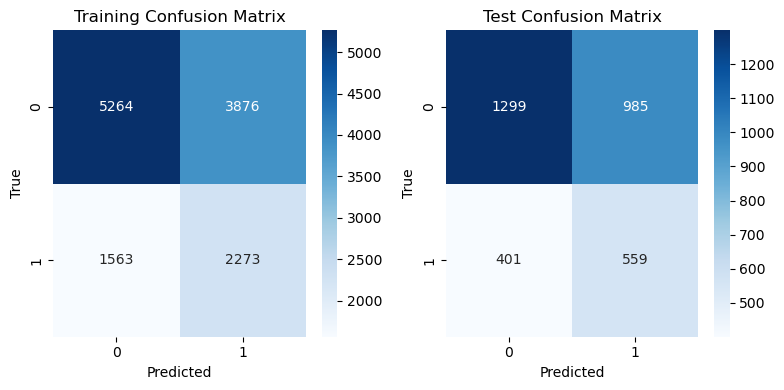

In [49]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegressionCV

# Initialize LogisticRegressionCV with balanced class weights and adjusted parameters
logreg_cv = LogisticRegressionCV(
    Cs=10,
    cv=5,
    penalty='l2',
    solver='lbfgs',
    max_iter=1000,
    random_state=42,
    scoring='recall',           # Changed from accuracy to f1 to better handle imbalance
    class_weight='balanced', # Add class weights to handle imbalance
    n_jobs=-1              # Use all available cores
)

# Fit the model using the original training data
logreg_cv.fit(X_train, y_train)

# Get training and test scores
logreg_train_score = logreg_cv.score(X_train, y_train)
logreg_test_score = logreg_cv.score(X_test, y_test)
print("\nLogistic Regression Scores:")
print(f"Training Score: {logreg_train_score:.3f}")
print(f"Test Score: {logreg_test_score:.3f}")

# Get predictions and probabilities
y_pred = logreg_cv.predict(X_test)
y_pred_proba = logreg_cv.predict_proba(X_test)

# Print detailed classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Generate confusion matrices for both training and test sets
y_train_pred = logreg_cv.predict(X_train)
train_cm = confusion_matrix(y_train, y_train_pred)
test_cm = confusion_matrix(y_test, y_pred)

# Create subplots for training and test confusion matrices
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

# Plot training confusion matrix
sns.heatmap(train_cm, annot=True, fmt='d', cmap='Blues', ax=ax1)
ax1.set_title('Training Confusion Matrix')
ax1.set_xlabel('Predicted')
ax1.set_ylabel('True')

# Plot test confusion matrix 
sns.heatmap(test_cm, annot=True, fmt='d', cmap='Blues', ax=ax2)
ax2.set_title('Test Confusion Matrix')
ax2.set_xlabel('Predicted')
ax2.set_ylabel('True')

plt.tight_layout()
plt.show()

Support vector machine


SVC Scores:
Training Score: 0.763
Test Score: 0.592

Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.66      0.70      2284
           1       0.35      0.43      0.38       960

    accuracy                           0.59      3244
   macro avg       0.54      0.55      0.54      3244
weighted avg       0.62      0.59      0.60      3244



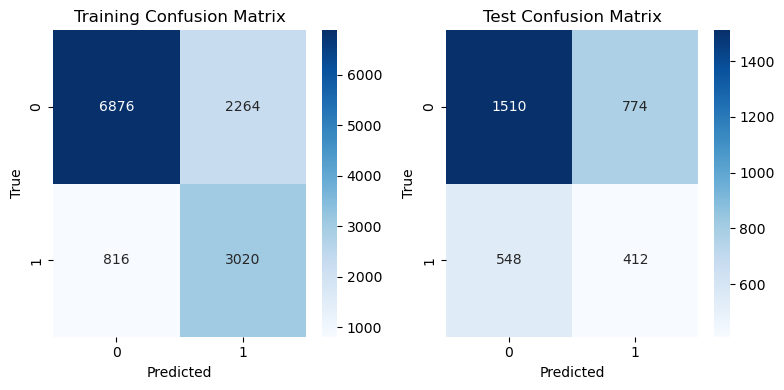

In [50]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.svm import SVC

# Initialize SVC with balanced class weights and adjusted parameters
svc = SVC(
    C=1.0,
    kernel='rbf', 
    gamma='scale',
    random_state=42,
    probability=True,
    class_weight='balanced'  # Add class weights to handle imbalance
)

# Fit the model using the original training data
svc.fit(X_train, y_train)

# Get training and test scores
svc_train_score = svc.score(X_train, y_train)
svc_test_score = svc.score(X_test, y_test)
print("\nSVC Scores:")
print(f"Training Score: {svc_train_score:.3f}")
print(f"Test Score: {svc_test_score:.3f}")

# Get predictions and probabilities
y_pred = svc.predict(X_test)
y_pred_proba = svc.predict_proba(X_test)

# Print detailed classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Generate confusion matrices for both training and test sets
y_train_pred = svc.predict(X_train)
train_cm = confusion_matrix(y_train, y_train_pred)
test_cm = confusion_matrix(y_test, y_pred)

# Create subplots for training and test confusion matrices
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

# Plot training confusion matrix
sns.heatmap(train_cm, annot=True, fmt='d', cmap='Blues', ax=ax1)
ax1.set_title('Training Confusion Matrix')
ax1.set_xlabel('Predicted')
ax1.set_ylabel('True')

# Plot test confusion matrix 
sns.heatmap(test_cm, annot=True, fmt='d', cmap='Blues', ax=ax2)
ax2.set_title('Test Confusion Matrix')
ax2.set_xlabel('Predicted')
ax2.set_ylabel('True')

plt.tight_layout()
plt.show()

Random forest classifier


Random Forest Scores:
Training Score: 1.000
Test Score: 0.700

Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.98      0.82      2284
           1       0.40      0.03      0.05       960

    accuracy                           0.70      3244
   macro avg       0.55      0.50      0.44      3244
weighted avg       0.61      0.70      0.59      3244



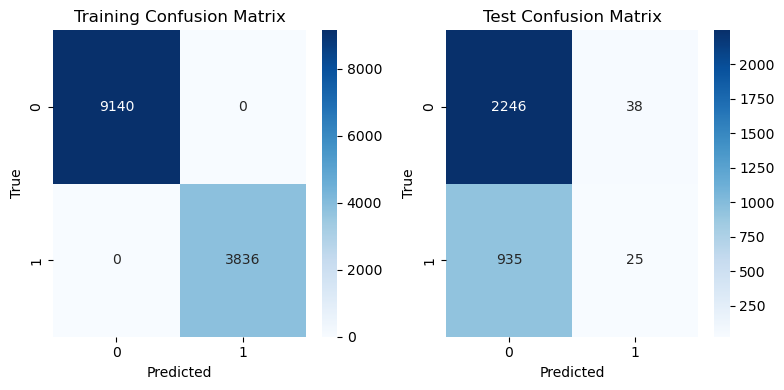


Top 10 Most Important Features:
     feature  importance
129      129    0.040812
0          0    0.033640
82        82    0.008380
29        29    0.007845
78        78    0.007823
77        77    0.007813
5          5    0.007782
88        88    0.007753
79        79    0.007668
102      102    0.007660


In [53]:
from sklearn.ensemble import RandomForestClassifier

# Initialize RandomForestClassifier with hyperparameters
rf = RandomForestClassifier(
    n_estimators=100,             # Number of trees in the forest
    max_depth=None,               # Maximum depth of trees
    min_samples_split=2,          # Minimum samples required to split node
    min_samples_leaf=1,           # Minimum samples required at leaf node
    random_state=42,
    n_jobs=-1,                     # Use all available cores
    class_weight='balanced'        # Account for class imbalance
)

# Fit the model using the training data
rf.fit(X_train, y_train)

# Get training and test scores
rf_train_score = rf.score(X_train, y_train)
rf_test_score = rf.score(X_test, y_test)
print("\nRandom Forest Scores:")
print(f"Training Score: {rf_train_score:.3f}")
print(f"Test Score: {rf_test_score:.3f}")

# Get predictions and probabilities
y_pred = rf.predict(X_test)
y_pred_proba = rf.predict_proba(X_test)

# Print detailed classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Generate confusion matrices for both training and test sets
y_train_pred = rf.predict(X_train)
train_cm = confusion_matrix(y_train, y_train_pred)
test_cm = confusion_matrix(y_test, y_pred)

# Create subplots for training and test confusion matrices
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

# Plot training confusion matrix
sns.heatmap(train_cm, annot=True, fmt='d', cmap='Blues', ax=ax1)
ax1.set_title('Training Confusion Matrix')
ax1.set_xlabel('Predicted')
ax1.set_ylabel('True')

# Plot test confusion matrix 
sns.heatmap(test_cm, annot=True, fmt='d', cmap='Blues', ax=ax2)
ax2.set_title('Test Confusion Matrix')
ax2.set_xlabel('Predicted')
ax2.set_ylabel('True')

plt.tight_layout()
plt.show()

# Feature importance
feature_importance = pd.DataFrame({
    'feature': range(X_train.shape[1]),
    'importance': rf.feature_importances_
})
print("\nTop 10 Most Important Features:")
print(feature_importance.sort_values('importance', ascending=False).head(10))


KNN


KNN (k=1) Scores:
Training Score: 1.000
Test Score: 0.598

KNN (k=2) Scores:
Training Score: 0.801
Test Score: 0.679

KNN (k=3) Scores:
Training Score: 0.794
Test Score: 0.635

KNN (k=4) Scores:
Training Score: 0.757
Test Score: 0.673

KNN (k=5) Scores:
Training Score: 0.753
Test Score: 0.648

KNN (k=6) Scores:
Training Score: 0.736
Test Score: 0.675

KNN (k=7) Scores:
Training Score: 0.736
Test Score: 0.652

KNN (k=8) Scores:
Training Score: 0.725
Test Score: 0.683

KNN (k=9) Scores:
Training Score: 0.727
Test Score: 0.665

KNN (k=10) Scores:
Training Score: 0.721
Test Score: 0.686


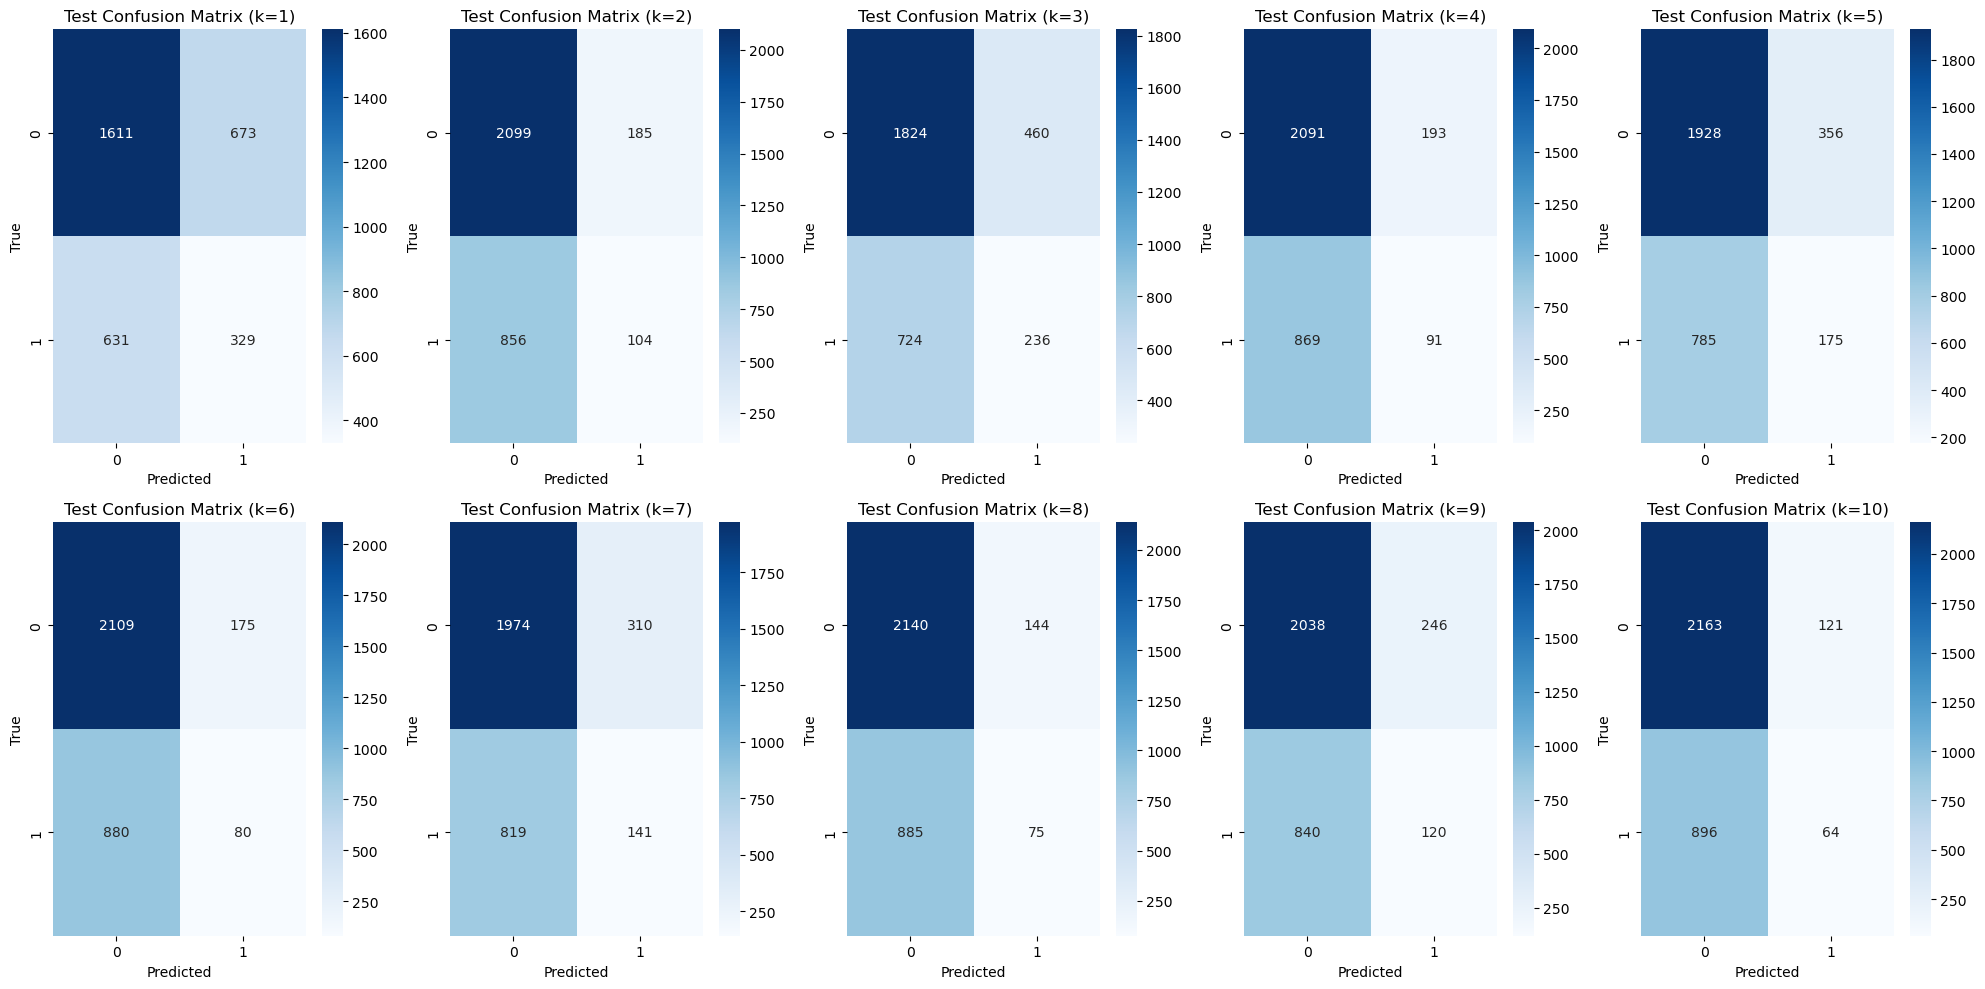


Best k=1 based on recall for disease class
Recall for disease class: 0.343

Full classification report:
              precision    recall  f1-score   support

           0       0.72      0.71      0.71      2284
           1       0.33      0.34      0.34       960

    accuracy                           0.60      3244
   macro avg       0.52      0.52      0.52      3244
weighted avg       0.60      0.60      0.60      3244



In [56]:
import numpy as np
from sklearn.metrics import recall_score

# KNN with different numbers of neighbors
plt.figure(figsize=(20, 10))

for n in range(1, 11):
    # Create and train KNN model
    knn = KNeighborsClassifier(n_neighbors=n)
    knn.fit(X_train, y_train)
    
    # Get training and test scores
    knn_train_score = knn.score(X_train, y_train)
    knn_test_score = knn.score(X_test, y_test)
    
    print(f"\nKNN (k={n}) Scores:")
    print(f"Training Score: {knn_train_score:.3f}")
    print(f"Test Score: {knn_test_score:.3f}")
    
    # Get predictions
    y_train_pred = knn.predict(X_train)
    y_test_pred = knn.predict(X_test)
    
    # Generate confusion matrices
    train_cm = confusion_matrix(y_train, y_train_pred)
    test_cm = confusion_matrix(y_test, y_test_pred)
    
    # Plot confusion matrices
    plt.subplot(2, 5, n)
    sns.heatmap(test_cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Test Confusion Matrix (k={n})')
    plt.xlabel('Predicted')
    plt.ylabel('True')

plt.tight_layout()
plt.show()
# Find best k based on recall for disease class (1)
recalls = []
k_values = range(1,11)

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    recall = recall_score(y_test, y_pred, pos_label=1)
    recalls.append(recall)

best_k = k_values[np.argmax(recalls)]

# Train final model with best k
best_knn = KNeighborsClassifier(n_neighbors=best_k)
best_knn.fit(X_train, y_train)
y_pred = best_knn.predict(X_test)

print(f"\nBest k={best_k} based on recall for disease class")
print(f"Recall for disease class: {recalls[best_k-1]:.3f}")
print("\nFull classification report:")
print(classification_report(y_test, y_pred))


#### Next steps
- Evaluate model performance using recall on training and testing sets. 
    - To evaluate which models we should 'trust' more, we will look at the recall for the disease class (save this for both training and testing sets for each model).
- Identify non-disease genes in test set that are classified as disease genes across all models.
    - Find the non-disease genes that are most frequently misclassified as disease genes. We are only looking for this in the testing set.
    - These are our candidate non-disease genes that may actually be disease genes.
    - This work flow serves as a proof of concept 'ensemble' approach for identifying non-disease genes that may actually be disease genes.

All training stuff is above this point ---------------------


PREDICTIONS ON NONDISEASE GENES

In [41]:
# Isolating non_disease nodes
all_node_ids = []
for id in vector_df["id"]:
    all_node_ids.append(id)

int_node_ids = []
non_disease_ids = []
for id in all_node_ids:
    if node_df.loc[id]["disease_assoc_cat"] == "disease_assoc" or node_df.loc[id]["disease_assoc_cat"] == "non_omim":
        int_node_ids.append(id)
    elif node_df.loc[id]["disease_assoc_cat"] == "non_disease_assoc":
        non_disease_ids.append(id)

print(len(int_node_ids))

# Isolating non-disease node embeddings in a df
unknown_rows = vector_df[vector_df["id"].isin(int_node_ids)]

unknown_vector_df = vector_df.drop(unknown_rows.index)

print(len(unknown_vector_df))

SyntaxError: invalid syntax (43216904.py, line 1)

In [42]:
# Predictions on nondisease genes

# Linear SVM Predictions
y_pred_lin_svm = svm_model.predict(unknown_vector_df)
y_pred_lin_svm = list(y_pred_lin_svm)
# print(y_pred_lin_svm)


# Kernel SVM Predictions
y_pred_ker_svm = kernelsvc_model.predict(unknown_vector_df)
y_pred_ker_svm = list(y_pred_ker_svm)
# print(y_pred_ker_svm)


# KNN Predictions
y_pred_knn = KNN.predict(unknown_vector_df)
y_pred_knn = list(y_pred_knn)
# print(y_pred_knn)


# RFC Predictions
y_pred_rfc = random_forest_classifier.predict(unknown_vector_df)
y_pred_rfc = list(y_pred_rfc)
# print(y_pred_rfc)

/Users/anusha/Desktop/Neuroinformatics_Internship/HopkinsGeneClassificationProj/envname/lib/python3.13/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but LinearSVC was fitted without feature names
  warnings.warn(
/Users/anusha/Desktop/Neuroinformatics_Internship/HopkinsGeneClassificationProj/envname/lib/python3.13/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(


['non_disease_assoc', 'non_disease_assoc', 'non_disease_assoc', 'non_disease_assoc', 'non_disease_assoc', 'non_disease_assoc', 'non_disease_assoc', 'non_disease_assoc', 'non_disease_assoc', 'non_disease_assoc', 'non_disease_assoc', 'non_disease_assoc', 'non_disease_assoc', 'non_disease_assoc', 'non_disease_assoc', 'non_disease_assoc', 'non_disease_assoc', 'non_disease_assoc', 'non_disease_assoc', 'non_disease_assoc', 'non_disease_assoc', 'non_disease_assoc', 'non_disease_assoc', 'non_disease_assoc', 'non_disease_assoc', 'non_disease_assoc', 'non_disease_assoc', 'non_disease_assoc', 'non_disease_assoc', 'non_disease_assoc', 'non_disease_assoc', 'non_disease_assoc', 'non_disease_assoc', 'non_disease_assoc', 'non_disease_assoc', 'non_disease_assoc', 'non_disease_assoc', 'non_disease_assoc', 'non_disease_assoc', 'non_disease_assoc', 'non_disease_assoc', 'non_disease_assoc', 'non_disease_assoc', 'non_disease_assoc', 'non_disease_assoc', 'non_disease_assoc', 'non_disease_assoc', 'non_disease

/Users/anusha/Desktop/Neuroinformatics_Internship/HopkinsGeneClassificationProj/envname/lib/python3.13/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(


['non_disease_assoc', 'non_disease_assoc', 'non_disease_assoc', 'non_disease_assoc', 'non_disease_assoc', 'non_disease_assoc', 'non_disease_assoc', 'non_disease_assoc', 'non_disease_assoc', 'non_disease_assoc', 'non_disease_assoc', 'non_disease_assoc', 'non_disease_assoc', 'non_disease_assoc', 'non_disease_assoc', 'non_disease_assoc', 'non_disease_assoc', 'non_disease_assoc', 'non_disease_assoc', 'non_disease_assoc', 'non_disease_assoc', 'non_disease_assoc', 'non_disease_assoc', 'non_disease_assoc', 'non_disease_assoc', 'non_disease_assoc', 'non_disease_assoc', 'non_disease_assoc', 'non_disease_assoc', 'non_disease_assoc', 'non_disease_assoc', 'non_disease_assoc', 'non_disease_assoc', 'non_disease_assoc', 'non_disease_assoc', 'non_disease_assoc', 'non_disease_assoc', 'non_disease_assoc', 'non_disease_assoc', 'non_disease_assoc', 'non_disease_assoc', 'non_disease_assoc', 'non_disease_assoc', 'non_disease_assoc', 'non_disease_assoc', 'non_disease_assoc', 'non_disease_assoc', 'non_disease

/Users/anusha/Desktop/Neuroinformatics_Internship/HopkinsGeneClassificationProj/envname/lib/python3.13/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


['non_disease_assoc', 'non_disease_assoc', 'non_disease_assoc', 'non_disease_assoc', 'non_disease_assoc', 'non_disease_assoc', 'non_disease_assoc', 'non_disease_assoc', 'non_disease_assoc', 'non_disease_assoc', 'non_disease_assoc', 'non_disease_assoc', 'non_disease_assoc', 'non_disease_assoc', 'non_disease_assoc', 'non_disease_assoc', 'non_disease_assoc', 'non_disease_assoc', 'non_disease_assoc', 'non_disease_assoc', 'non_disease_assoc', 'non_disease_assoc', 'non_disease_assoc', 'non_disease_assoc', 'non_disease_assoc', 'non_disease_assoc', 'non_disease_assoc', 'non_disease_assoc', 'non_disease_assoc', 'non_disease_assoc', 'non_disease_assoc', 'non_disease_assoc', 'non_disease_assoc', 'non_disease_assoc', 'non_disease_assoc', 'non_disease_assoc', 'non_disease_assoc', 'non_disease_assoc', 'non_disease_assoc', 'non_disease_assoc', 'non_disease_assoc', 'non_disease_assoc', 'non_disease_assoc', 'non_disease_assoc', 'non_disease_assoc', 'non_disease_assoc', 'non_disease_assoc', 'non_disease

In [49]:
for item in y_pred_rfc:
    if item == 'disease_assoc':
        print(item)

In [61]:
#KNN

# Predictions
y_train_pred_knn = KNN.predict(X_train)
y_val_pred_knn = KNN.predict(X_val)
y_test_pred_knn = KNN.predict(X_test)

# Probabilities for ROC curve
y_train_prob_knn = KNN.predict_proba(X_train)[:, 1]
y_val_prob_knn = KNN.predict_proba(X_val)[:, 1]
y_test_prob_knn = KNN.predict_proba(X_test)[:, 1]

# 1. Accuracy and F1 Score
train_acc_knn = accuracy_score(y_train, y_train_pred_knn)
val_acc_knn = accuracy_score(y_val, y_val_pred_knn)
test_acc_knn = accuracy_score(y_test, y_test_pred_knn)

train_f1_knn = f1_score(y_train, y_train_pred_knn)
val_f1_knn = f1_score(y_val, y_val_pred_knn)
test_f1_knn = f1_score(y_test, y_test_pred_knn)

# Log Loss (for Loss plot)
train_loss_knn = log_loss(y_train, y_train_prob_knn)
val_loss_knn = log_loss(y_val, y_val_prob_knn)
test_loss_knn = log_loss(y_test, y_test_prob_knn)

In [58]:
#RFC

# Predictions
y_train_pred_rfc = random_forest_classifier.predict(X_train)
y_val_pred_rfc = random_forest_classifier.predict(X_val)
y_test_pred_rfc = random_forest_classifier.predict(X_test)

# Probabilities for ROC curve
y_train_prob_rfc = random_forest_classifier.predict_proba(X_train)[:, 1]
y_val_prob_rfc = random_forest_classifier.predict_proba(X_val)[:, 1]
y_test_prob_rfc = random_forest_classifier.predict_proba(X_test)[:, 1]

# 1. Accuracy and F1 Score
train_acc_rfc = accuracy_score(y_train, y_train_pred_rfc)
val_acc_rfc = accuracy_score(y_val, y_val_pred_rfc)
test_acc_rfc = accuracy_score(y_test, y_test_pred_rfc)

train_f1_rfc = f1_score(y_train, y_train_pred_rfc)
val_f1_rfc = f1_score(y_val, y_val_pred_rfc)
test_f1_rfc = f1_score(y_test, y_test_pred_rfc)

# Log Loss (for Loss plot)
train_loss_rfc = log_loss(y_train, y_train_prob_rfc)
val_loss_rfc = log_loss(y_val, y_val_prob_rfc)
test_loss_rfc = log_loss(y_test, y_test_prob_rfc)

In [59]:
# 2. Plot Bar Graph for Loss, Accuracy, F1 Score
def plot_metrics_bar(train_acc, val_acc, test_acc, train_f1, val_f1, test_f1, train_loss, val_loss, test_loss):
    metrics = ['Accuracy', 'F1 Score', 'Loss']
    
    # Values for each metric
    train_metrics = [train_acc, train_f1, train_loss]
    val_metrics = [val_acc, val_f1, val_loss]
    test_metrics = [test_acc, test_f1, test_loss]
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))  # 1 row, 3 columns
    
    # Plot each metric as bar plots
    for i, metric in enumerate(metrics):
        axes[i].bar(['Train', 'Validation', 'Test'], 
                    [train_metrics[i], val_metrics[i], test_metrics[i]], 
                    color=['blue', 'orange', 'green'])
        axes[i].set_title(f'{metric} Bar Plot')
        axes[i].set_ylabel(metric)
        axes[i].set_xlabel('Dataset Split')
    
    plt.tight_layout()
    plt.show()

plot_metrics_bar(train_acc_rfc, val_acc_rfc, test_acc_rfc, train_f1_rfc, val_f1_rfc, test_f1_rfc, train_loss_rfc, val_loss_rfc, test_loss_rfc)


# 3. Confusion Matrix
def plot_confusion_matrices(y_train, y_train_pred, y_val, y_val_pred, y_test, y_test_pred):
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))  # 1 row, 3 columns
    splits = ['Training', 'Validation', 'Test']
    preds = [(y_train, y_train_pred), (y_val, y_val_pred), (y_test, y_test_pred)]
    
    for i, (y_true, y_pred) in enumerate(preds):
        cm = confusion_matrix(y_true, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i])
        axes[i].set_title(f'{splits[i]} Confusion Matrix')
        axes[i].set_xlabel('Predicted Label')
        axes[i].set_ylabel('True Label')
    
    plt.tight_layout()
    plt.show()

plot_confusion_matrices(y_train, y_train_pred_rfc, y_val, y_val_pred_rfc, y_test, y_test_pred_rfc)

# 4. ROC Curves and Optimal Threshold Calculation
def calculate_roc_curve(y_true, y_prob):
    fpr, tpr, thresholds = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)
    return fpr, tpr, thresholds, roc_auc


results = {}
for split, (y_true, y_prob) in zip(['train', 'val', 'test'], [(y_train, y_train_prob_rfc), (y_val, y_val_prob_rfc), (y_test, y_test_prob_rfc)]):
    fpr, tpr, thresholds, roc_auc = calculate_roc_curve(y_true, y_prob)
    results[f'{split}_fpr'] = fpr
    results[f'{split}_tpr'] = tpr
    results[f'{split}_thresholds'] = thresholds
    results[f'{split}_roc_auc'] = roc_auc

# Plot ROC Curves
def plot_roc_curves(results):
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))  # Create 1 row with 3 subplots
    titles = ["Training ROC Curve", "Validation ROC Curve", "Test ROC Curve"]
    
    for i, metric in enumerate(['train', 'val', 'test']):
        fpr = results[f'{metric}_fpr']
        tpr = results[f'{metric}_tpr']
        roc_auc = results[f'{metric}_roc_auc']
        thresholds = results[f'{metric}_thresholds']
        
        # Compute the Youden's J statistic for each threshold
        youdens_j = tpr - fpr
        optimal_idx = numpy.argmax(youdens_j)  # Get the index of the max J statistic
        optimal_threshold = thresholds[optimal_idx]
        optimal_fpr = fpr[optimal_idx]
        optimal_tpr = tpr[optimal_idx]
        
        # Plot the ROC curve
        RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc).plot(ax=axes[i])
        axes[i].set_title(f'{metric.capitalize()} ROC Curve')

        # Highlight the optimal threshold
        axes[i].scatter(optimal_fpr, optimal_tpr, color='red', label=f'Optimal Threshold: {optimal_threshold:.2f}')
        axes[i].annotate(f'Threshold: {optimal_threshold:.2f}\nTPR: {optimal_tpr:.2f}, FPR: {optimal_fpr:.2f}',
                         xy=(optimal_fpr, optimal_tpr), xycoords='data',
                         xytext=(-50, 40), textcoords='offset points',
                         arrowprops=dict(facecolor='black', shrink=0.05),
                         fontsize=10, color='black')

        axes[i].legend(loc='lower right')
    
    plt.tight_layout()
    plt.show()

plot_roc_curves(results)

In [42]:
# 2. Plot Bar Graph for Loss, Accuracy, F1 Score
def plot_metrics_bar(train_acc, val_acc, test_acc, train_f1, val_f1, test_f1, train_loss, val_loss, test_loss):
    metrics = ['Accuracy', 'F1 Score', 'Loss']
    
    # Values for each metric
    train_metrics = [train_acc, train_f1, train_loss]
    val_metrics = [val_acc, val_f1, val_loss]
    test_metrics = [test_acc, test_f1, test_loss]
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))  # 1 row, 3 columns
    
    # Plot each metric as bar plots
    for i, metric in enumerate(metrics):
        axes[i].bar(['Train', 'Validation', 'Test'], 
                    [train_metrics[i], val_metrics[i], test_metrics[i]], 
                    color=['blue', 'orange', 'green'])
        axes[i].set_title(f'{metric} Bar Plot')
        axes[i].set_ylabel(metric)
        axes[i].set_xlabel('Dataset Split')
    
    plt.tight_layout()
    plt.show()

plot_metrics_bar(train_acc_knn, val_acc_knn, test_acc_knn, train_f1_knn, val_f1_knn, test_f1_knn, train_loss_knn, val_loss_knn, test_loss_knn)


# 3. Confusion Matrix
def plot_confusion_matrices(y_train, y_train_pred, y_val, y_val_pred, y_test, y_test_pred):
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))  # 1 row, 3 columns
    splits = ['Training', 'Validation', 'Test']
    preds = [(y_train, y_train_pred), (y_val, y_val_pred), (y_test, y_test_pred)]
    
    for i, (y_true, y_pred) in enumerate(preds):
        cm = confusion_matrix(y_true, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i])
        axes[i].set_title(f'{splits[i]} Confusion Matrix')
        axes[i].set_xlabel('Predicted Label')
        axes[i].set_ylabel('True Label')
    
    plt.tight_layout()
    plt.show()

plot_confusion_matrices(y_train, y_train_pred_knn, y_val, y_val_pred_knn, y_test, y_test_pred_knn)

# Define a mapping function
def map_values(x):
    mapping = {
            0: 'disease_assoc',
            1: 'non_disease_assoc',
            2: 'non_omim'
        }

# 4. ROC Curves and Optimal Threshold Calculation
def calculate_roc_curve(y_true, y_prob):
    fpr, tpr, thresholds = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)

    mapped_y_true = y_true.vectorize(map_values)
    return fpr, tpr, thresholds, roc_auc


results = {}
for split, (y_true, y_prob) in zip(['train', 'val', 'test'], [(y_train, y_train_prob_knn), (y_val, y_val_prob_knn), (y_test, y_test_prob_knn)]):
    fpr, tpr, thresholds, roc_auc = calculate_roc_curve(y_true, y_prob)
    results[f'{split}_fpr'] = fpr
    results[f'{split}_tpr'] = tpr
    results[f'{split}_thresholds'] = thresholds
    results[f'{split}_roc_auc'] = roc_auc

# Plot ROC Curves
def plot_roc_curves(results):
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))  # Create 1 row with 3 subplots
    titles = ["Training ROC Curve", "Validation ROC Curve", "Test ROC Curve"]
    
    for i, metric in enumerate(['train', 'val', 'test']):
        fpr = results[f'{metric}_fpr']
        tpr = results[f'{metric}_tpr']
        roc_auc = results[f'{metric}_roc_auc']
        thresholds = results[f'{metric}_thresholds']
        
        # Compute the Youden's J statistic for each threshold
        youdens_j = tpr - fpr
        optimal_idx = numpy.argmax(youdens_j)  # Get the index of the max J statistic
        optimal_threshold = thresholds[optimal_idx]
        optimal_fpr = fpr[optimal_idx]
        optimal_tpr = tpr[optimal_idx]
        
        # Plot the ROC curve
        RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc).plot(ax=axes[i])
        axes[i].set_title(f'{metric.capitalize()} ROC Curve')

        # Highlight the optimal threshold
        axes[i].scatter(optimal_fpr, optimal_tpr, color='red', label=f'Optimal Threshold: {optimal_threshold:.2f}')
        axes[i].annotate(f'Threshold: {optimal_threshold:.2f}\nTPR: {optimal_tpr:.2f}, FPR: {optimal_fpr:.2f}',
                         xy=(optimal_fpr, optimal_tpr), xycoords='data',
                         xytext=(-50, 40), textcoords='offset points',
                         arrowprops=dict(facecolor='black', shrink=0.05),
                         fontsize=10, color='black')

        axes[i].legend(loc='lower right')
    
    plt.tight_layout()
    plt.show()

plot_roc_curves(results)

In [14]:
# Bayesian Optimization hyperparameter tuning

# LinearSVC
param_space_linear_svc = {
    'C': (1e-4, 1e+2, 'log-uniform'),  # Regularization parameter
    'max_iter': (100, 1000)             # Maximum number of iterations
}

# Using BayesSearchCV for Bayesian Optimization
linear_opt = BayesSearchCV(svm_model, param_space_linear_svc, n_iter=50, cv=5, n_jobs=-1, random_state=42)

# Fit the model
linear_opt.fit(X_train_scaled, y_train)

# Best parameters and score
print("Linear best parameters:", linear_opt.best_params_)
print("Linear best cross-validation score:", linear_opt.best_score_)

# Evaluate on the test set
y_pred_linear = linear_opt.predict(X_test_scaled)
test_accuracy_linear = accuracy_score(y_test, y_pred_linear)
print("Linear test set accuracy:", test_accuracy_linear)

# ALL CODE IS THE SAME [ONLY MODEL IS DIFFERENT] -- no comments written bc everything is the same
# KernelSVC
param_space_kernel_svc = {
    'C': (1e-4, 1e+2, 'log-uniform'),   # Regularization parameter
    'gamma': (1e-4, 1e+1, 'log-uniform'), # Kernel coefficient
    'kernel': ['linear', 'rbf', 'poly'], # Kernel type
    'degree': (2, 5)                     # Degree for polynomial kernel
}

kernel_opt = BayesSearchCV(kernelsvc_model, param_space_kernel_svc, n_iter=50, cv=5, n_jobs=-1, random_state=42)
kernel_opt.fit(X_train_scaled, y_train)
print("Kernel best parameters:", kernel_opt.best_params_)
print("Kernel best cross-validation score:", kernel_opt.best_score_)
y_pred_kernel = kernel_opt.predict(X_test_scaled)
test_accuracy_kernel = accuracy_score(y_test, y_pred_kernel)
print("Kernel test set accuracy:", test_accuracy_kernel)

# Random Forest Classifier
param_space_random_forest = {
    'n_estimators': (10, 100),           # Number of trees in the forest
    'max_depth': (None, 5, 10, 15),      # Maximum depth of the tree
    'min_samples_split': (2, 10),        # Minimum number of samples required to split an internal node
    'max_features': ['auto', 'sqrt']     # Number of features to consider when looking for the best split
}

rfc_opt = BayesSearchCV(random_forest_classifier, param_space_random_forest, n_iter=50, cv=5, n_jobs=-1, random_state=42)
rfc_opt.fit(X_train_scaled, y_train)
print("RFC best parameters:", rfc_opt.best_params_)
print("RFC best cross-validation score:", rfc_opt.best_score_)
y_pred_rfc = rfc_opt.predict(X_test_scaled)
test_accuracy_rfc = accuracy_score(y_test, y_pred_rfc)
print("RFC test set accuracy:", test_accuracy_rfc)

# KNN
param_space_knn = {
    'n_neighbors': (1, 20),              # Number of neighbors
    'weights': ['uniform', 'distance'],   # Weight function used in prediction
    'metric': ['euclidean', 'manhattan']  # Distance metric
}

knn_opt = BayesSearchCV(KNN, param_space_knn, n_iter=50, cv=5, n_jobs=-1, random_state=42)
knn_opt.fit(X_train_scaled, y_train)
print("KNN best parameters:", knn_opt.best_params_)
print("KNN best cross-validation score:", knn_opt.best_score_)
y_pred_knn = knn_opt.predict(X_test_scaled)
test_accuracy_knn = accuracy_score(y_test, y_pred_knn)
print("KNN test set accuracy:", test_accuracy_knn)


In [ ]:
# # GridSearch CV hyperparameter tuning
# # defining parameter range 
# param_grid = {'loss':['hinge', 'squared_hinge'],
#               'tol': [1, 0.1, 0.01, 0.001, 0.0001],
#               'C': [0.1, 1, 10, 100, 1000],
#               'max_iter':[1000, 3000, 5000]   
#               }  
  
# grid = GridSearchCV(svm_model, param_grid, refit = True, verbose = 3) 
  
# # fitting the model for grid search 
# grid.fit(X_train, y_train) 

# # print best parameter after tuning 
# print(grid.best_params_) 
  
# # print how our model looks after hyper-parameter tuning 
# print(grid.best_estimator_) 

# grid_predictions = grid.predict(X_test) 
  
# # print classification report 
# print(classification_report(y_test, grid_predictions)) 